In [100]:
import hyperimp.evaluate.importance as hyperimp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import openml
import numpy as np

In [101]:
# load traces
with open('01 data/exp2/trace_data.pickle', 'rb') as handle:
     traces = pickle.load(handle)
        
# load accuracy data
with open('01 data/exp2/acc_data.pickle', 'rb') as handle:
     data = pickle.load(handle)
        
# remove datasets for which accuracy = 1
data = data[~data['task'].isin(['11', '10093', '49'])]

# Average rank

In [119]:
# compute ranks
ranks = {}
for parameter in ['min_samples_split', 'criterion', 'max_features', 'min_samples_leaf', 'bootstrap']:
    if parameter in ['max_features', 'gamma']:
        deftypes = ['sklearn', 'hyperimp']
    else:
        deftypes = ['None']
    for deftype in deftypes:
        nf_ranks_tot = 100 * [0]
        f_ranks_tot = 100 * [0]
        num = 0
        for task in data['task'].unique():
            for seed in data['seed'].unique():
                nf_runid = list(data[(data['parameter'] == 'None') & (data['task'] == task) &
                                  (data['seed'] == seed) & (data['classifier'] == 'random_forest')]['run_id'])[0]
                f_run = list(data[(data['parameter'] == parameter) & (data['task'] == task) &
                              (data['seed'] == seed) & (data['classifier'] == 'random_forest') &
                                 (data['deftype'] == deftype)]['run_id'])
                if len(f_run) == 1:
                    f_runid = f_run[0]
                else:
                    break
                nf_ranks = []
                f_ranks = []
                for nf, f in zip(traces[nf_runid], traces[f_runid]):
                    if nf > f:
                        rank_nf = 1
                        rank_f = 2
                    elif f > nf:
                        rank_f = 1
                        rank_nf = 2
                    elif nf == f:
                        rank_f = 1.5
                        rank_nf = 1.5
                    nf_ranks.append(rank_nf)
                    f_ranks.append(rank_f)
                nf_ranks_tot = np.add(nf_ranks_tot, nf_ranks)
                f_ranks_tot = np.add(f_ranks_tot, f_ranks)
                num += 1
        nf_ranks_avg = nf_ranks_tot/num
        f_ranks_avg = f_ranks_tot/num
        ranks[(parameter, deftype)] = {'nf_avg' : nf_ranks_avg, 'f_avg' : f_ranks_avg}

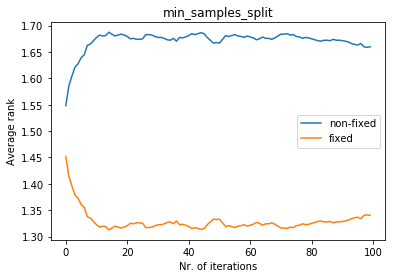

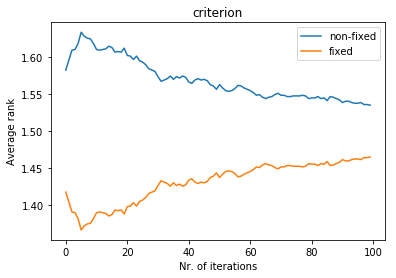

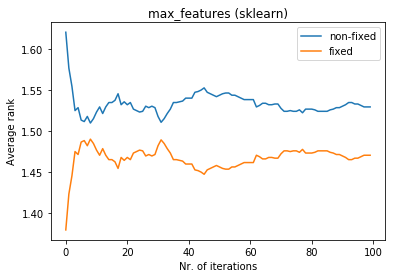

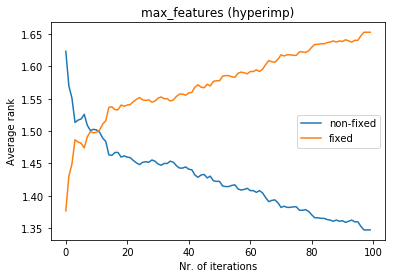

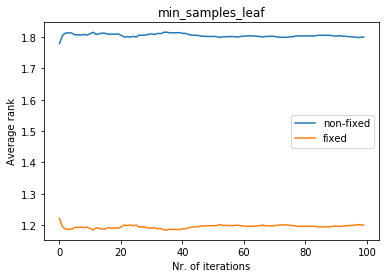

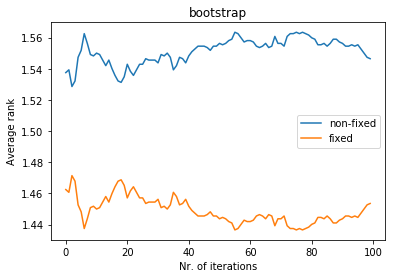

In [120]:
for key, value in ranks.items():
    plt.plot(value['nf_avg'], label = 'non-fixed')
    plt.plot(value['f_avg'], label = 'fixed')
    plt.xlabel("Nr. of iterations")
    plt.ylabel("Average rank")
    plt.legend()
    if key[0] == 'max_features':
        title = '%s (%s)' % (key[0], key[1])
    else:
        title = key[0]
    plt.title(title)
    plt.show()

# Tunability


In [3]:
# Compute risk scores for non-fixed condition
non_fixed_dict = {}
for task in data['task'].unique():
    for seed in data['seed'].unique():
        for classifier in ['random_forest', 'svm']:
            record = data[(data['parameter'] == 'None') & (data['task'] == task) &
                          (data['seed'] == seed) & (data['classifier'] == classifier)]
            if len(record) == 1:
                non_fixed_risk = 1 - list(record['acc_openml'])[0]
            else:
                non_fixed_risk = None
                print('No data found for task %s, seed %s, classifier %s' %(task, seed, classifier))
            non_fixed_dict[(task, seed, classifier)] = non_fixed_risk

In [4]:
# Create lists of paired risks for each hyperparameter
risks = {}
for parameter in ['min_samples_split', 'criterion', 'max_features', 'min_samples_leaf', 
                  'bootstrap', 'gamma', 'shrinking', 'tol', 'C']:
    if parameter in ['min_samples_split', 'criterion', 'max_features', 'min_samples_leaf', 'bootstrap']:
        classifier = 'random_forest'
    elif parameter in ['gamma', 'shrinking', 'tol', 'C']:
        classifier = 'svm'
    if parameter in ['max_features', 'gamma']:
        deftypes = ['sklearn', 'hyperimp']
    else: 
        deftypes = ['None']
    for deftype in deftypes:
        fixed = []
        non_fixed = []
        for task in data['task'].unique():
            if task == '3904':
                None
            else:
                for seed in data['seed'].unique():
                    record = data[(data['parameter'] == parameter) & (data['task'] == task) &
                                  (data['seed'] == seed) & (data['deftype'] == deftype)]
                    if len(record) == 1:
                        fixed_risk = 1 - list(record['acc_openml'])[0]
                        non_fixed_risk = non_fixed_dict[(task, seed, classifier)]
                        fixed.append(fixed_risk)
                        non_fixed.append(non_fixed_risk)
                    else:
                        print('Error for parameter %s, task %s, seed %s, deftype %s.' % (parameter, task, seed, deftype))
        risk_parameter = {'fixed' : fixed, 'non_fixed' : non_fixed}
        risks[(parameter, deftype)] = risk_parameter

In [96]:
all_scores = []
all_scores_rel = []
parameters = []

tunabilities = {}
for key, risk in risks.items():
    fixed = risk['fixed']
    non_fixed = risk['non_fixed']
    scores = hyperimp.tunability(fixed, non_fixed)
    scores_rel = hyperimp.relative_tunability(fixed, non_fixed)
    scores_rel = [x for x in scores_rel if not np.isnan(x)]
    parameter = key[0]
    if parameter == 'max_features' or parameter == 'gamma':
        parameter = '%s (%s)' % (key[0], key[1])
    parameters.append(parameter)
    tunabilities[key] = {
        'avg. tunability' : np.mean(scores),
        'std. tunability' : np.std(scores),
        'avg. rel. tunability' : np.mean(scores_rel),
        'std. rel. tunability' : np.std(scores_rel)}
    all_scores.append(scores)
    all_scores_rel.append(scores_rel)
    
pd.options.display.float_format = '{:,.4f}'.format
display(pd.DataFrame(tunabilities).transpose()[['avg. tunability', 'std. tunability', 
                                               'avg. rel. tunability', 'std. tunability']])
pd.reset_option('float_format')

avg. tunability  std. tunability  \
C                 None               0.0008           0.0062   
bootstrap         None              -0.0002           0.0053   
criterion         None              -0.0002           0.0041   
gamma             hyperimp           0.0180           0.0599   
                  sklearn            0.0039           0.0115   
max_features      hyperimp           0.0011           0.0068   
                  sklearn            0.0010           0.0134   
min_samples_leaf  None              -0.0030           0.0077   
min_samples_split None              -0.0009           0.0048   
shrinking         None              -0.0000           0.0005   
tol               None              -0.0001           0.0016   

                            avg. rel. tunability  std. tunability  
C                 None                    0.0252           0.0062  
bootstrap         None                   -0.0053           0.0053  
criterion         None                    0.0035           0.0041  
gamma             hyperimp                0.4595           0.0599  
                  sklearn                 0.0503           0.0115  
max_features      hyperimp                0.0742           0.0068  
                  sklearn                 0.0309           0.0134  
min_samples_leaf  None                   -0.0505           0.0077  
min_samples_split None                   -0.0110           0.0048  
shrinking         None                   -0.0003           0.0005  
tol               None                    0.0006           0.0016

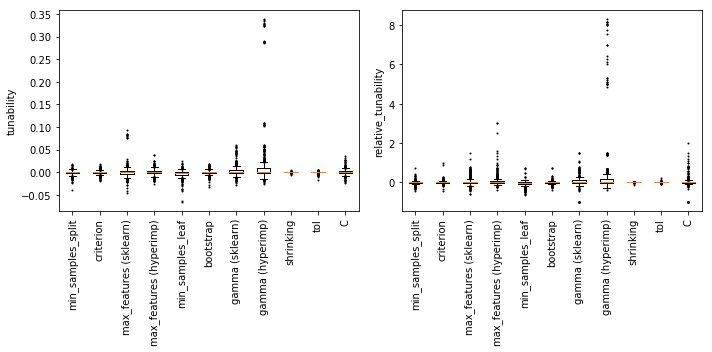

In [97]:
grid = True # put images on grid or not

if grid:
    cols = 2 # set nr columns in figure grid
    rows = 1
    plt.figure(figsize = (5*cols,5*rows))
    index = 0

for scores, label in zip([all_scores, all_scores_rel], ['tunability', 'relative_tunability']):
    if grid:
        index += 1
        plt.subplot(rows, cols, index)
    plt.xticks(rotation=90)
    plt.boxplot(scores, labels = parameters, flierprops = {'markersize' : 1})
    plt.ylabel(label)
    plt.tight_layout()
    if not grid:
        plt.savefig('02 figures/tunability/boxplot__%s.pdf' % (label), format = 'pdf')
        plt.show()
if grid:
    plt.show()

# Non-inferiority

In [7]:
delta = 0.01
alpha = 0.05

non_inferiority = {}
for key, risk in risks.items():
    fixed = risk['fixed']
    non_fixed = risk['non_fixed']
    z, p = hyperimp.noninferior(fixed, non_fixed, delta, alpha)
    if p >= 0.05:
        conclusion = 'H0 rejected: non-inferior'
    else:
        conclusion = "H0 not rejected: inferior"
    non_inferiority[key] = {'test statistic' : z, 'p-value' : p, "rejection" : conclusion}
display(pd.DataFrame(non_inferiority).transpose())

p-value                  rejection  \
C                 None        0.0566455  H0 rejected: non-inferior   
bootstrap         None      6.01877e-15  H0 not rejected: inferior   
criterion         None      1.00338e-15  H0 not rejected: inferior   
gamma             hyperimp   7.9805e-17  H0 not rejected: inferior   
                  sklearn   1.12669e-06  H0 not rejected: inferior   
max_features      hyperimp    0.0157456  H0 not rejected: inferior   
                  sklearn    0.00034927  H0 not rejected: inferior   
min_samples_leaf  None      1.09192e-50  H0 not rejected: inferior   
min_samples_split None      3.10615e-23  H0 not rejected: inferior   
shrinking         None      5.36863e-92  H0 not rejected: inferior   
tol               None      1.17404e-58  H0 not rejected: inferior   

                           test statistic  
C                 None            1.58357  
bootstrap         None            7.71564  
criterion         None            7.94093  
gamma             hyperimp       -8.24909  
                  sklearn        -4.72926  
max_features      hyperimp       -2.15081  
                  sklearn         3.39015  
min_samples_leaf  None            14.9275  
min_samples_split None            9.85988  
shrinking         None            20.3089  
tol               None            16.1051

In [13]:
import scipy
delta = 0.01
alpha = 0.05

z_norm = scipy.stats.norm.ppf(1 - alpha)

equivalence = {}
for key, risk in risks.items():
    fixed = risk['fixed']
    non_fixed = risk['non_fixed']
    z1, p1, z2, p2 = hyperimp.equivalence(fixed, non_fixed, delta, alpha)
    if z1 >= z_norm:
        conclusion1 = "H01 rejected"
    else:
        conclusion1 = "H01 not rejected"
    if z2 >= z_norm:
        conclusion2 = 'H02 rejected'
    else:
        conclusion2 = 'H02 not rejected'
    
    if conclusion1 == "H01 rejected" and conclusion2 == 'H02 rejected':
        conclusion = 'equivalent'
    elif conclusion1 == 'H01 rejected':
        conclusion = 'non-inferior'
    else:
        conclusion = 'None'
    equivalence[key] = {'test statistic 1' : z1, 'p-value 1' : '%.5f' % p1, 'conclusion 1' : conclusion1,
                        'test statistic 2' : z2, 'p-value 2' : '%.5f' % p2, 'conclusion 2' : conclusion2,
                       'verdict' : conclusion}
display(pd.DataFrame(equivalence).transpose())

conclusion 1      conclusion 2 p-value 1  \
C                 None      H01 not rejected      H02 rejected   0.05665   
bootstrap         None          H01 rejected      H02 rejected   0.00000   
criterion         None          H01 rejected      H02 rejected   0.00000   
gamma             hyperimp  H01 not rejected      H02 rejected   0.00000   
                  sklearn   H01 not rejected      H02 rejected   0.00000   
max_features      hyperimp  H01 not rejected      H02 rejected   0.01575   
                  sklearn       H01 rejected      H02 rejected   0.00035   
min_samples_leaf  None          H01 rejected  H02 not rejected   0.00000   
min_samples_split None          H01 rejected  H02 not rejected   0.00000   
shrinking         None          H01 rejected      H02 rejected   0.00000   
tol               None          H01 rejected      H02 rejected   0.00000   

                           p-value 2 test statistic 1 test statistic 2  \
C                 None       0.00000          1.58357          7.60863   
bootstrap         None       0.00016          7.71564          3.59425   
criterion         None       0.00000          7.94093          7.03683   
gamma             hyperimp   0.00000         -8.24909          12.7942   
                  sklearn    0.00000         -4.72926          9.63299   
max_features      hyperimp   0.00000         -2.15081          9.21084   
                  sklearn    0.01636          3.39015          2.13552   
min_samples_leaf  None       0.00000          14.9275         -8.86192   
min_samples_split None       0.33617          9.85988         0.422948   
shrinking         None       0.00000          20.3089           19.876   
tol               None       0.00000          16.1051          16.3706   

                                 verdict  
C                 None              None  
bootstrap         None        equivalent  
criterion         None        equivalent  
gamma             hyperimp          None  
                  sklearn           None  
max_features      hyperimp          None  
                  sklearn     equivalent  
min_samples_leaf  None      non-inferior  
min_samples_split None      non-inferior  
shrinking         None        equivalent  
tol               None        equivalent

In [14]:
import scipy
delta = 0.01
alpha = 0.025

z_norm = scipy.stats.norm.ppf(1 - alpha)

equivalence = {}
for key, risk in risks.items():
    fixed = risk['fixed']
    non_fixed = risk['non_fixed']
    z1, p1, z2, p2 = hyperimp.equivalence_nonrel(fixed, non_fixed, delta, alpha)
    if z1 >= z_norm:
        conclusion1 = "H01 rejected"
    else:
        conclusion1 = "H01 not rejected"
    if z2 >= z_norm:
        conclusion2 = 'H02 rejected'
    else:
        conclusion2 = 'H02 not rejected'
    
    if conclusion1 == "H01 rejected" and conclusion2 == 'H02 rejected':
        conclusion = 'equivalent'
    elif conclusion1 == 'H01 rejected':
        conclusion = 'non-inferior'
    else:
        conclusion = 'None'
    equivalence[key] = {'test statistic 1' : z1, 'p-value 1' : '%.5f' % p1, 'conclusion 1' : conclusion1,
                        'test statistic 2' : z2, 'p-value 2' : '%.5f' % p2, 'conclusion 2' : conclusion2,
                       'verdict' : conclusion}
display(pd.DataFrame(equivalence).transpose())

conclusion 1  conclusion 2 p-value 1 p-value 2  \
C                 None      H01 rejected  H02 rejected   0.00000   0.00000   
bootstrap         None      H01 rejected  H02 rejected   0.00000   0.00000   
criterion         None      H01 rejected  H02 rejected   0.00000   0.00000   
gamma             hyperimp  H01 rejected  H02 rejected   0.00000   0.00000   
                  sklearn   H01 rejected  H02 rejected   0.00000   0.00000   
max_features      hyperimp  H01 rejected  H02 rejected   0.00000   0.00000   
                  sklearn   H01 rejected  H02 rejected   0.00000   0.00000   
min_samples_leaf  None      H01 rejected  H02 rejected   0.00000   0.00000   
min_samples_split None      H01 rejected  H02 rejected   0.00000   0.00000   
shrinking         None      H01 rejected  H02 rejected   0.00000   0.00000   
tol               None      H01 rejected  H02 rejected   0.00000   0.00000   

                           test statistic 1 test statistic 2     verdict  
C                 None              18.8842          19.8779  equivalent  
bootstrap         None               20.075          19.7607  equivalent  
criterion         None              20.2552          20.1745  equivalent  
gamma             hyperimp           7.9766          19.7566  equivalent  
                  sklearn            13.295          19.7218  equivalent  
max_features      hyperimp          18.7048           19.762  equivalent  
                  sklearn           17.7634          18.5497  equivalent  
min_samples_leaf  None              20.0879          17.5445  equivalent  
min_samples_split None              20.2279          19.6821  equivalent  
shrinking         None              20.3193          20.3193  equivalent  
tol               None              20.3193          20.3158  equivalent